<a href="https://colab.research.google.com/github/KuanChihLee/Supervised-Learning/blob/master/Assignment4_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This assignment section implements Gaussian and histogram kernel density estimation for IPOs dataset

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import random
from math import sqrt, ceil, floor
from numpy.linalg import inv
from statistics import stdev

import csv

csv_file = "./IPO_dataset.csv"

# Saving CSV file to dataframe
df_IPO = pd.read_csv(csv_file, names=['ID', 'Venture_Fund', 'Face_Value', 'Offer_shares', 'Lev_Buyout'])
print(df_IPO.shape)
df_IPO.head(3)

(482, 5)


,ID,Venture_Fund,Face_Value,Offer_shares,Lev_Buyout
0,1,0,1200000,3000000,0
1,2,0,1454000,1454000,1
2,3,0,1500000,300000,0


In [0]:
Train = df_IPO.sample(frac=0.7, random_state=20)
df_IPO = df_IPO.drop(Train.index)
Dev = df_IPO.sample(frac=0.7, random_state=20)
Eval = df_IPO.drop(Dev.index)

del Train['ID']
del Dev['ID']
del Eval['ID']
print("Train size:", Train.shape)
print("Dev size:",Dev.shape)
print("Eval size:",Eval.shape)
Train.head(10)

Train size: (337, 4)
Dev size: (102, 4)
Eval size: (43, 4)


,Venture_Fund,Face_Value,Offer_shares,Lev_Buyout
13,0,3150000,450000,0
471,0,114000000,6000000,0
63,0,5850000,900000,0
328,0,29700000,3300000,0
185,1,15000000,1500000,0
179,1,14700000,2100000,0
156,0,13000000,1625000,0
372,0,35000000,5000000,0
365,1,33350000,2300000,0
362,1,32500000,2500000,0


#### Gaussian kernel density estimation using class stddev as bandwith- question 3(a)

In [0]:
def _Gaussian_Kernerl(x, mean, stdev):
    fx = (1 / (np.sqrt(2 * np.pi) * stdev)) * np.exp(-(pow(x - mean, 2) / (2 * pow(stdev, 2))))
    return fx

def _ProbByClass(mean_vectors, stdev_vectors, prior_vectors, observation):
    probabilities = {}
    prob_x = 0
    for clas in range(len(prior_vectors)):
        probabilities[clas] = prior_vectors[clas]
        for predictor in range(len(mean_vectors[clas])):
            mean, stdev = mean_vectors[clas][predictor], stdev_vectors[clas][predictor]
            x = observation[predictor]
            probabilities[clas] *= _Gaussian_Kernerl(x, mean, stdev)
        prob_x += probabilities[clas]
    for clas in range(len(prior_vectors)):
        probabilities[clas] /= prob_x
    return probabilities

def predict(mean_vectors, stdev_vectors, prior_vectors, dataset):
    predictions = []
    for index in range(dataset.shape[0]):
        probabilities = _ProbByClass(mean_vectors, stdev_vectors, prior_vectors, dataset[index])
        best_label, best_prob = None, -1
        for clas, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_label = clas
                best_prob = probability
        predictions.append(best_label)
    return predictions

def getAccuracy(y, predictions):
    correct = 0
    for index in range(len(y)):
        if y[index] == predictions[index]:
            correct += 1
    return (correct/float(len(y))) * 100.0

In [0]:
predictor_num = Train.shape[1] - 1
class_num = len(np.unique(Train.Venture_Fund.values))

X_train = Train.drop("Venture_Fund", axis=1).values
y_train = Train.Venture_Fund.values
X_dev = Dev.drop("Venture_Fund", axis=1).values
y_dev = Dev.Venture_Fund.values
X_eval = Eval.drop("Venture_Fund", axis=1).values
y_eval = Eval.Venture_Fund.values

X_train[:,0] = np.log1p(X_train[:,0])
X_train[:,1] = np.log1p(X_train[:,1])
X_dev[:,0] = np.log1p(X_dev[:,0])
X_dev[:,1] = np.log1p(X_dev[:,1])
X_eval[:,0] = np.log1p(X_eval[:,0])
X_eval[:,1] = np.log1p(X_eval[:,1])

mean_vectors = []
stdev_vectors = []
prior_vectors = []
for clas in range(0, class_num):
    x = X_train[y_train==clas]
    mean_vectors.append(np.mean(x, axis=0))
    stdev_vectors.append(np.sqrt(sum(pow(x - mean_vectors[clas], 2)) / (x.shape[0] - 1)))
    prior_vectors.append(x.shape[0] / X_train.shape[0])
predictions = predict(mean_vectors, stdev_vectors, prior_vectors, X_train)
accurary = getAccuracy(y_train, predictions)
print("Accurary on Training set: ", accurary, "%")
 
predictions = predict(mean_vectors, stdev_vectors, prior_vectors, X_dev)
accurary = getAccuracy(y_dev, predictions)
print("Accurary on Eval set: ", accurary, "%")

Accurary on Training set:  64.68842729970326 %
Accurary on Eval set:  65.68627450980392 %


Short summary: Just remember the accuracy we obtain, on training and validation set, are about 64~66% 

#### Choosing Lambda from validation set- question 3(b)

In [0]:
def _Gaussian_Kernerl_BD(x, mean, stdev):
    fx = (1 / (np.sqrt(2 * np.pi) * stdev)) * np.exp(-(pow(x - mean, 2) / (2 * pow(stdev, 2))))
    return fx

def _ProbByClass_BD(mean_vectors, lamdas, prior_vectors, observation):
    probabilities = {}
    prob_x = 0
    for clas in range(len(prior_vectors)):
        probabilities[clas] = prior_vectors[clas]
        for predictor in range(len(mean_vectors[clas])):
            mean, stdev = mean_vectors[clas][predictor], lamdas[clas]
            x = observation[predictor]
            probabilities[clas] *= _Gaussian_Kernerl_BD(x, mean, stdev)
        prob_x += probabilities[clas]
    for clas in range(len(prior_vectors)):
        probabilities[clas] /= prob_x
    return probabilities

def predict_BD(mean_vectors, lamdas, prior_vectors, dataset):
    predictions = []
    for index in range(dataset.shape[0]):
        probabilities = _ProbByClass_BD(mean_vectors, lamdas, prior_vectors, dataset[index])
        best_label, best_prob = None, -1
        for clas, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_label = clas
                best_prob = probability
        predictions.append(best_label)
    return predictions

def getAccuracy(y, predictions):
    correct = 0
    for index in range(len(y)):
        if y[index] == predictions[index]:
            correct += 1
    return (correct/float(len(y))) * 100.0

In [0]:
mean_vectors = []
stdev_vectors = []
prior_vectors = []
for clas in range(0, class_num):
    x = X_train[y_train==clas]
    mean_vectors.append(np.mean(x, axis=0))
    prior_vectors.append(x.shape[0] / X_train.shape[0])
predictions = predict_BD(mean_vectors, [0.01, 0.05], prior_vectors, X_train)
accurary = getAccuracy(y_train, predictions)
print("Accurary on Training set: ", accurary, "%")
 
predictions = predict_BD(mean_vectors, [0.01, 0.05], prior_vectors, X_dev)
accurary = getAccuracy(y_dev, predictions)
print("Accurary on Eval set: ", accurary, "%")

Accurary on Training set:  46.29080118694362 %
Accurary on Eval set:  57.84313725490197 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [0]:
mean_vectors = []
stdev_vectors = []
prior_vectors = []

for clas in range(0, class_num):
    x = X_train[y_train==clas]
    mean_vectors.append(np.mean(x, axis=0))
    prior_vectors.append(x.shape[0] / X_train.shape[0])
    
lamda_range = np.linspace(.01, 10, num=30)
lamda_vectors = []
for i in lamda_range:
    for j in lamda_range:
        lamda_vectors.append([i, j])
    
accurary = []
for lamdas in lamda_vectors:    
    predictions = predict_BD(mean_vectors, lamdas, prior_vectors, X_dev)
    accurary.append(getAccuracy(y_dev, predictions))
    index_max = np.argmax(accurary)

print("Accurary on Dev set: ", np.max(accurary), "%")
print("Chosen Lambdas: ", lamda_vectors[index_max])    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Accurary on Dev set:  67.64705882352942 %
Chosen Lambdas:  [1.0434482758620691, 0.6989655172413793]


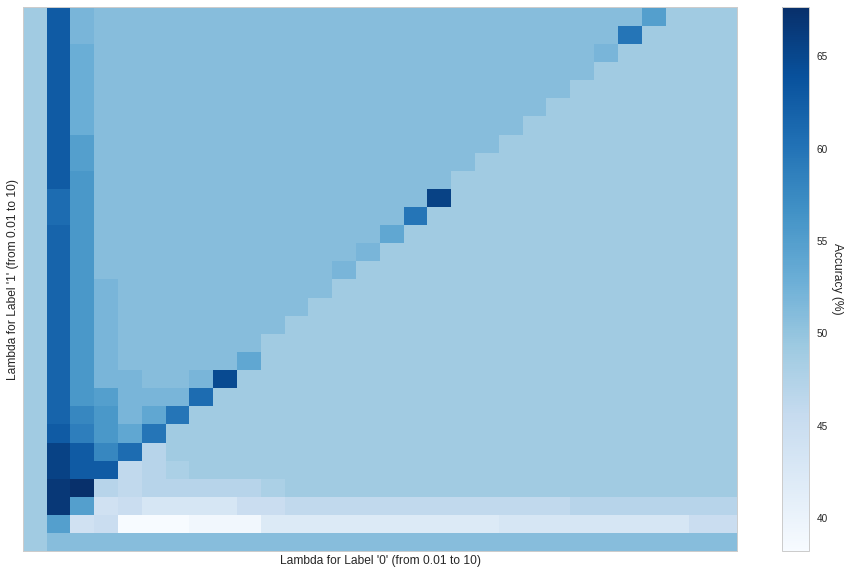

In [0]:
lamda_list = [la for la in lamda_range]
acc_matrix = np.array(accurary).reshape(len(lamda_list),len(lamda_list))

fig, ax = plt.subplots(figsize=(16,10))
heatmap = ax.pcolor(acc_matrix, cmap=plt.cm.Blues) # heatmap contient les valeurs

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Lambda for Label '0' (from 0.01 to 10)", size=12)
ax.set_ylabel("Lambda for Label '1' (from 0.01 to 10)", size=12)
cbar = plt.colorbar(heatmap)
cbar.set_label('Accuracy (%)', size=12, rotation=270, labelpad=15)

#### Report the predictive performance on the evaluation set

In [0]:
fixed_lamda = lamda_vectors[index_max]
predictions = predict_BD(mean_vectors, fixed_lamda, prior_vectors, X_eval)
acc = getAccuracy(y_eval, predictions)
print("Accurary on Eval set: ", acc, "%")

Accurary on Eval set:  69.76744186046511 %


1. As a result, the accuracy of evaluation set is about 69%. Although it's a pretty result, it's a better result compared with logistic regression I used in Assignment 3. Also, I don't need to extend the feature domain, such as higher dimension and interaction terms. 
2. Based on last assignment experience, this assignment only adopts log transformation to numeric features. I don't add any higher-order terms to increase model complexity. I want to see the basic performance for Gaussian kernel NB model and Kernel Density Estimation.